In [1]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

## UMAP

In [2]:
embedding = pd.read_csv("D:/data/VeloRM_data/RNA-Seq_A-to-I/origin/embedding_data.csv", index_col=0)
pre_TPM = pd.read_csv("D:/data/VeloRM_data/RNA-Seq_A-to-I/origin/pre_TPM_index_pre_spliced.csv", index_col=0)
spliced_TPM = pd.read_csv("D:/data/VeloRM_data/RNA-Seq_A-to-I/origin/spliced_TPM_index_pre_spliced.csv", index_col=0)
cell_colors = pd.read_csv("D:/data/VeloRM_data/RNA-Seq_A-to-I/origin/cell_colors_data.csv", index_col=0)

In [3]:
common_cells = list(set(pre_TPM.columns) & set(spliced_TPM.columns) & set(cell_colors.index))
pre_TPM = pre_TPM[common_cells]
spliced_TPM = spliced_TPM[common_cells]
cell_colors = cell_colors.loc[common_cells]

spliced = spliced_TPM.T
unspliced = pre_TPM.T

In [4]:
adata = ad.AnnData(X=np.log1p(spliced) ) # log1p
adata.layers["spliced"] = np.log1p(spliced.values)
adata.layers["unspliced"] = np.log1p(unspliced.values)

adata.obs_names = spliced.index
adata.var_names = spliced.columns

# embedding
adata.obsm["X_embedding"] = embedding.loc[adata.obs_names].values
adata.obs["phase"] = cell_colors.astype("category")

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
scv.pp.moments(adata, n_pcs=50, n_neighbors=30)

# ============ Step 4: velocity ============
scv.tl.velocity(adata, mode="stochastic")
scv.tl.velocity_graph(adata)
scv.tl.velocity_confidence(adata)

computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.


D:\Anaconda3\envs\scvelo\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_embedding', embedded velocity vectors (adata.obsm)


D:\Anaconda3\envs\scvelo\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
D:\Anaconda3\envs\scvelo\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


saving figure to file ./figures/scvelo_scvelo_plot_RNA_seq_A_to_I.svg


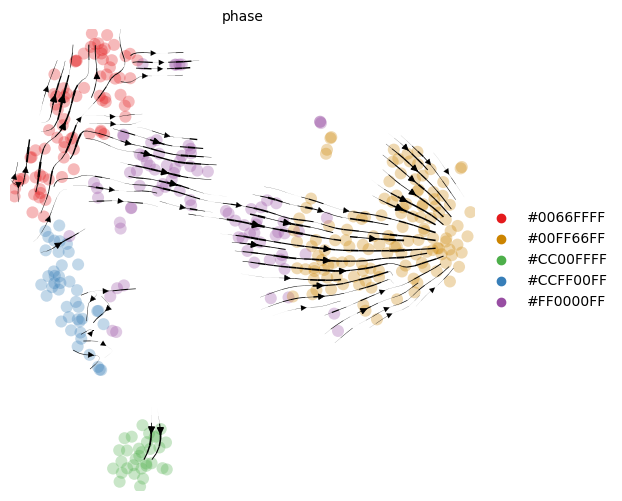

In [6]:
# plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="embedding",
    color="phase",
    palette=[
        "#E41A1C",  
        "#CC8400",    
        "#4DAF4A",  
        "#377EB8",  
        "#984EA3"  
    ],  
    size=300,            # point
    legend_loc="right",
    figsize=(6, 6),
    save='scvelo_plot_RNA_seq_A_to_I.svg'
)
